# 2025 CITS4012 Group 9 Assignment

**Collaborators**

| Uni ID   | Student Name  | GitHub Username                                   |
| -------- | ------------- | ------------------------------------------------- |
| 24141207 | Kaichao Zheng | [Kaichao-Zheng](https://github.com/Kaichao-Zheng) |
| 24645175 | Ziqi Meng     | [jiongge39](https://github.com/jiongge39)         |
| 23998001 | Yanglei Yuan  | [LeoYuan0225](https://github.com/LeoYuan0225)     |

# Readme
这是Project 1的模板，我直接拿来用了

仅需注重代码风格及可视化，让marker改起来舒服就行，分数低不了的
* 例如：多抄Lab的技术栈，多引用学界的基石论文，marker自然乐意审自己熟悉的技术。e.g., WordCloud Visualization

*If there is something to be noted for the marker, please mention here.*

*If you are planning to implement a program with Object *Oriented* Programming style, please put those the bottom of this ipynb file*

# 0. Setup

> NOTE:
>
> In Google Colab, an ERROR would occur due to incompatibility of the latest versions of `numpy` and `scipy`.
>
> Simply **restart the runtime** to use the newly downgraded versions.

In [ ]:
%pip install word2number
%pip install contractions
%pip install nltk
%pip install pandas
%pip install gensim

# 1. Overview

We implemented three substantially different model architectures:

* [The vanilla RNN encoder-decoder architecture](#scrollTo=67TQJgOJ_lF1)

* [The Bi-LSTM encoder-decoder with XXX-attention in different positions](#scrollTo=BhSE5ON4_r0C)

* [The vanilla Transformer with self-attention (no RNN)](#scrollTo=E4w_n2P2_xxm)

# 2. Data Preprocessing

## 2.1 Load JSON files from GitHub



In [ ]:
# Define JSON dataset paths
base_url = "https://raw.githubusercontent.com/Kaichao-Zheng/CITS4012-NLP/main/"

train_file = base_url + "train.json"
val_file = base_url + "validation.json"
test_file = base_url + "test.json"

# Quick check
print("✅ Dataset URLs:")
print("Train:\t", train_file)
print("Val:\t", val_file)
print("Test:\t", test_file)

In [ ]:
import pandas as pd

# Working dataframes
train_df = pd.read_json(train_file)
val_df = pd.read_json(val_file)
test_df = pd.read_json(test_file)

# Keep original copies
source_train_df = train_df.copy()
source_val_df = val_df.copy()
source_test_df = test_df.copy()

# Sneak peek
pd.set_option("display.max_colwidth", 30)

print(train_df.head())
# print(val_df.head())
# print(test_df.head())

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

pd.reset_option("display.max_colwidth")

## 2.2 Define difference viewer

In [ ]:
import html
from difflib import SequenceMatcher
from IPython.display import display, HTML

def verify_print(source_df, cleaned_df, tag, num, col, idx_src ,idx_now, kept=False):
  status = "Kept " if kept else "Reindexed"
  print(f"{tag} {num}:\tidx_src: {idx_src}\t{source_df[col][idx_src]}")
  print(f"{status} {num}:\tidx_now: {idx_now}\t{cleaned_df[col][idx_now]}")
  print()

# You can enable dark mode by replacing default "light" here
def verify_diff(source_df, cleaned_df, tag, num, col, index, kept=False, theme="dark"):
  if theme == "light":
    bg = "#fafafa"; fg = "#000000"
    del_bg = "#ffdddd"; ins_bg = "#ddffdd"
    del_fg = "#aa0000"; ins_fg = "#006600"
  else:
    bg = "#1e1e1e"; fg = "#e0e0e0"
    del_bg = "#662222"; ins_bg = "#224422"
    del_fg = "#ff9999"; ins_fg = "#99ff99"

  status = "Kept" if kept else "Fixed"

  original = source_df[col][index]
  cleaned = cleaned_df[col][index]

  matcher = SequenceMatcher(None, original, cleaned)

  html_original = f"""
  <div style='margin-bottom: 10px; background-color:{bg}; color:{fg}; white-space: nowrap; font-family: monospace; padding: 5px; border-radius:4px;'>
  <b>{tag} {num}:</b> """
  html_cleaned = f"""
  <div style='margin-bottom: 10px; background-color:{bg}; color:{fg}; white-space: nowrap; font-family: monospace; padding: 5px; border-radius:4px;'>
  <b>{status} {num}:</b> """

  for tag, i1, i2, j1, j2 in matcher.get_opcodes():
    orig_text = original[i1:i2].replace(" ", "&nbsp;")
    clean_text = cleaned[j1:j2].replace(" ", "&nbsp;")

    if tag == 'equal':
      html_original += orig_text
      html_cleaned += clean_text
    elif tag == 'delete':
      html_original += f"<span style='background-color:{del_bg}; color:{del_fg};'>{orig_text}</span>"
    elif tag == 'insert':
      html_cleaned += f"<span style='background-color:{ins_bg}; color:{ins_fg};'>{clean_text}</span>"
    elif tag == 'replace':
      html_original += f"<span style='background-color:{del_bg}; color:{del_fg};'>{orig_text}</span>"
      html_cleaned += f"<span style='background-color:{ins_bg}; color:{ins_fg};'>{clean_text}</span>"

  html_original += "</div>"
  html_cleaned += "</div>"

  display(HTML(html_original + html_cleaned + "<hr/>"))

## 2.3 Data cleansing

In principle, the data cleansing rules are derived solely from the training set to prevent information leakage.

This design intentionally preserves out-of-vocabulary (OOV) cases in the validation and test sets, which are represented by \<UNK> tag.

Assumption
* The value of `label` is binary, either "neutral" or "entails".

Compromises
* Ignore syntactic errors and semantic errors.
* Apply unified premises rules on hypothesis.

Handled Issues
| No. | Description | Examples |
|----------|-------------|-----------|
| Issue 1 | HTML/XML tags with ID pattern | train premise 78, 270, 319, ... |
| Issue 2 | Non-linguistic long/pure separators | train premise 1, 382, 385, ... |
| Issue 3 | Duplicate consecutive phrases | train premise 78, 87, 564, ... |
| Issue 4 | Single-word sentences  | train premise 146, 181, 427, ... |
| Issue 5 | Duplicated whitespaces | train premise 123, 193, 259, ... |
| Issue 6 | Spaces before punctuations, except '!' and '?' | train premise 3, 333, 6280 |
| Issue 7 | Premise with long concatenated sentences | train premise 270, 537, 608, ... |

Kept Noises

| No. | Description | Noise | Non-Noise |
|----------|-------------|----------|--------------|
| Noise 1 | Instructional prompt words | train premise 3, 61, 319, ... | train premise 16, 24, 61, ... |
| Noise 2 | Numbered markers | train premise 270, 537, 608, ... | train premise 1546, 2068, ... |
| Noise 3 | Misplaced `label` values | train premise 270, 537, 606, ... | train premise 1683, 2068, ... |
| Noise 4 | Metadata prefixes | train premise 32, 230, 482, ... |  |
| Noise 4 | Isolated single symbols | train premise 60, 1185 | comparison operators |


Limitation

The difference viewer automatically escapes HTML entities, which might overlook HTML noise. (E.g., &amp;quot; in train premise 420)

In [ ]:
import re

def cleanse(df):
  df = df.copy()

  ID_PATTERN = r"\b[A-Za-z]?(?:\d{6,}|[A-Za-z0-9]{8,})(?:-[A-Za-z0-9]{2,})+\b"
  REPEAT_PATTERN = r"\b((?:\w+\s+){0,2}\w+)( \1\b)+"

  for col in ["premise", "hypothesis"]:

    # pre-trim: two-tailed whitespaces
    df[col] = df[col].apply(lambda x: x.strip())

    # issue 1: HTML/XML tags with ID pattern
    df[col] = df[col].apply(html.unescape)
    df[col] = df[col].apply(lambda x: re.sub(r"<[^>]*>", " ", x))
    df[col] = df[col].apply(lambda x: re.sub(ID_PATTERN, " ", x))

    # issue 2: non-linguistic long/pure separators
    df[col] = df[col].apply(lambda x: re.sub(r"[-=*_~$]{3,}", " ", x))
    df[col] = df[col].apply(lambda x: "" if re.fullmatch(r"[\W_]+", x.strip()) else x)

    # issue 3: duplicate consecutive phrases
    df[col] = df[col].apply(lambda x: re.sub(REPEAT_PATTERN, r"\1", x))

    # issue 4: single-word sentences
    df[col] = df[col].apply(lambda x: "" if re.fullmatch(r"(\w+[.!?']?|[^\w\s]+)", x.strip()) else x)

    # issue 5: duplicate whitespaces
    df[col] = df[col].apply(lambda x: re.sub(r"\s+", " ", x).strip())

    # issue 6: spaces before punctuations
    df[col] = df[col].apply(lambda x: re.sub(r"\s+([.,;:])", r"\1", x))

  return df

# Clenasing
train_df = cleanse(train_df)
val_df = cleanse(val_df)
test_df = cleanse(test_df)

# Keep cleaned copies
cleaned_train_df = train_df.copy()
cleaned_val_df = val_df.copy()
cleaned_test_df = test_df.copy()

# Verification
verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=1, col="premise", index=319)
verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=2, col="premise", index=1)
verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=3, col="premise", index=87)
verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=4, col="premise", index=146)
verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=5, col="premise", index=123)
verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=6, col="premise", index=3)
# verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=6, col="premise", index=6280, kept=True)  # why except '?'
# verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=6, col="premise", index=333, kept=True)  # why except '!'
verify_diff(source_train_df, cleaned_train_df, tag="Issue", num="Hybrid", col="premise", index=270)

## 2.4 Normalization

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
sww = stopwords.words('english')

In [ ]:
import re, contractions
from nltk.tokenize import word_tokenize, sent_tokenize
from word2number import w2n
from contractions import fix as expand_contractions

def word2num(text):
  def convert(match):
    word = match.group(0)
    try:
      return f" {w2n.word_to_num(word)} "
    except:
      return f" {word} "
  text = re.sub(
    r'\b(?:zero|one|two|three|four|five|six|seven|eight|nine|ten|'
    r'eleven|twelve|thirteen|fourteen|fifteen|sixteen|seventeen|'
    r'eighteen|nineteen|twenty|thirty|forty|fifty|sixty|seventy|'
    r'eighty|ninety|hundred|thousand|million|billion|and|[- ])+\b',
    convert, text)
  return ' '.join(text.split())

def normalize(df):
  df = df.copy()

  for col in ["premise", "hypothesis"]:

    # rule 1: lowercase
    df[col] = df[col].str.lower()

    # rule 2: expand contraction
    df[col] = df[col].apply(expand_contractions)

    # rule -1: remove stopwords
    # df[col] = df[col].apply(lambda x: " ".join([w for w in word_tokenize(x) if w.lower() not in sww]))

    # rule -2: remove bracketed content
    # df[col] = df[col].apply(lambda x: re.sub(r'\([^)]*\)', '', x))

    # rule -3: symbolize linguistic numbers
    # df[col] = df[col].apply(word2num)

  return df

# Normalization
train_df = normalize(train_df)
val_df = normalize(val_df)
test_df = normalize(test_df)

# Keep normalized copies
normalized_train_df = train_df.copy()
normalized_val_df = val_df.copy()
normalized_test_df = test_df.copy()

# Verification
verify_diff(cleaned_train_df, normalized_train_df, tag="Rule", num="1", col="premise", index=1)
verify_diff(cleaned_train_df, normalized_train_df, tag="Rule", num="2", col="premise", index=420)
verify_diff(cleaned_train_df, normalized_train_df, tag="Rule", num="2", col="hypothesis", index=8, kept=True)

# Inactivate rules
# verify_diff(cleaned_train_df, normalized_train_df, tag="Rule", num=-1, col="premise", index=1, kept=True)
# verify_diff(cleaned_train_df, normalized_train_df, tag="Rule", num=-2, col="premise", index=8, kept=True)
# verify_diff(cleaned_train_df, normalized_train_df, tag="Rule", num=-3, col="premise", index=147, kept=True)

## 2.5 Reindexing

In [ ]:
def reindex(df):
  df = df.copy()

  for col in ["premise", "hypothesis"]:

    # post-issue 4: remove rows with empty cell
    df = df[df[col].astype(str).str.strip() != ""]

  # issue 7: premise with long concatenated sentences
  new_rows = []
  for _, row in df.iterrows():
    premise = str(row["premise"]).strip()
    hypothesis = str(row["hypothesis"]).strip()
    label = str(row["label"]).strip()

    if not premise:
      continue

    # split by ". " or "; " to avoid 3.14
    sentences = re.split(r'(?<!\d)(?<=[.;])\s+(?=[A-Za-z])', premise)
    sentences = [s.strip() for s in sentences if s.strip()]

    for s in sentences:
      new_rows.append({
        "premise": s,
        "hypothesis": hypothesis,
        "label": label
      })
  df = pd.DataFrame(new_rows)

  # reorder index
  df = df.reset_index(drop=True)

  return df

# Reindexing
train_df = reindex(train_df)
val_df = reindex(val_df)
test_df = reindex(test_df)

# Keep reindexed copies
reindexed_train_df = train_df.copy()
reindexed_val_df = val_df.copy()
reindexed_test_df = test_df.copy()

# Verification
verify_print(normalized_train_df, reindexed_train_df, tag="Post-Issue", num=4, col="premise", idx_src=147, idx_now=158)
verify_print(normalized_train_df, reindexed_train_df, tag="Issue", num=7, col="premise", idx_src=31, idx_now=31, kept=True)
verify_print(normalized_train_df, reindexed_train_df, tag="Issue", num=7, col="premise", idx_src=270, idx_now=281)

## 2.6 Tokenization

In [ ]:
import nltk
nltk.download('punkt_tab')

In [ ]:
import string

def protect_float(text: str) -> str:
  return re.sub(r"(?<=\d)\.(?=\d)", "DOTTK", text)

def recover_float(tokens):
  return [t.replace("DOTTK", ".") for t in tokens]

def tokenize(df):
  df = df.copy()
  KEEP_SYMBOLS = set("=<>+-/*%!")

  for col in ["premise", "hypothesis"]:
    # Remove punctuations
    df[col] = df[col].apply(lambda x: protect_float(x))
    df[col] = df[col].apply(lambda x: [t for t in word_tokenize(x) if t not in string.punctuation or t in KEEP_SYMBOLS])
    df[col] = df[col].apply(lambda toks: recover_float(toks))

  return df

# Tokenization
tokenized_train_df = tokenize(train_df)
tokenized_val_df = tokenize(val_df)
tokenized_test_df = tokenize(test_df)

# Quick check
preview_rows = pd.concat([
  tokenized_train_df.head(),
  tokenized_train_df.iloc[[6, 23, 34, 62, 369, 438, 2116]]  # concatenate indeces 6, 23, 32, 60, 319, 385, 1185
])

display(preview_rows)

## 2.7 Visualisation via Word Cloud

We actually include stopwords in the tokenized dataframes for model training,

but temporarily remove them here for visualisation purposes.

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)
sww = stopwords.words('english')

for col in ["premise", "hypothesis"]:
  tokens = []
  # Remove punctuation, number, and stopword tokens temporarily
  for toks in tokenized_train_df[col]:
    tokens.extend([t.lower() for t in toks if t.isalpha() and t.lower() not in sww])
  wordcloud = WordCloud(background_color="white").generate(" ".join(tokens))
  plt.figure()
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.title(f"{col.capitalize()} Word Cloud (Train Set)")
  plt.show()

# 3. Word Embedding

## 3.1 Signal tags

We chose to add \<EOS> after premise to signal the end of the input sequence.

In [ ]:
def tag_seq2seq(df):
  df = df.copy()

  # Encoder input sequences
  df["premise"] = df["premise"].apply(lambda s: s + ["<EOS>"])

  # Decoder input sequences
  df["hypothesis_in"] = df["hypothesis"].apply(lambda s: ["<BOS>"] + s)

  # Decoder target sequences for teacher forcing
  df["hypothesis_tar"] = df["hypothesis"].apply(lambda s: s + ["<EOS>"])

  return df

# Reorder columns
order = ["premise","hypothesis_in","hypothesis_tar","label"]

train_df = tag_seq2seq(tokenized_train_df)[order]
val_df = tag_seq2seq(tokenized_val_df)[order]
test_df = tag_seq2seq(tokenized_test_df)[order]

display(train_df.head())

## 3.2 Token vocabulary

The vocabulary only includes tokens in train set with `frequency >= 3`.

Therefore, a token with low frequency will be regarded as \<UNK>.

E.g. the token "6.39" from the first premise.

In [ ]:
from collections import Counter

def build_vocab(tagged_df, min_freq=3):
  counter = Counter()
  for col in ["premise", "hypothesis"]:
    for toks in tagged_df[col]:
      counter.update(toks)

  # special tokens
  vocab = {"<PAD>": 0,"<UNK>": 1,"<BOS>": 2,"<EOS>": 3}
  for token, freq in counter.items():
    if freq >= min_freq and token not in vocab:
      vocab[token] = len(vocab)

  return vocab

vocab = build_vocab(tokenized_train_df)
print("Vocab size:", {len(vocab)})
print("Sample tokens:", list(vocab.keys())[:20])

## 3.3 One-hot key embedding

Map each token to its one-hot key from the vocabulary.

In [ ]:
def word_to_index(df, vocab):
  df = df.copy()

  for col in ["premise", "hypothesis_in", "hypothesis_tar"]:
    df[col] = df[col].apply(lambda toks: [vocab.get(w, vocab["<UNK>"]) for w in toks])

  label_map = {"neutral": 0, "entails": 1}
  if "label" in df.columns:
    df["label"] = df["label"].map(label_map).fillna(-1).astype(int)

  return df

# One-hot key embedding
indexed_train_df = word_to_index(train_df, vocab)
indexed_val_df = word_to_index(val_df, vocab)
indexed_test_df = word_to_index(test_df, vocab)

display(indexed_train_df.head())

# 4. Model Implementation

## 4.1 Training Configuration

### 4.1.1 Enable cuda GPU

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 4.1.2 Shared hyperparameters


In [ ]:
from types import SimpleNamespace

shared = SimpleNamespace(
  vocab_size = len(vocab),
  embed_dim = 256,
  hidden_dim = 256,
  num_layers = None,      # number of recurrent layers differs across models
  dropout = 0.1,
  batch_size = 128,
  learning_rate = 1e-3,
  total_epoch = 20,
  pad_idx = vocab["<PAD>"],
  unk_idx = vocab["<UNK>"],
  bos_idx = vocab["<BOS>"],
  eos_idx = vocab["<EOS>"],
)

### 4.1.3 Padding

In [ ]:
def pad(seq, max_len):
  return seq + [shared.pad_idx] * (max_len - len(seq))

def pad_seq(df):
  df = df.copy()

  max_prem = max(df["premise"].apply(len))
  max_hypo_in = max(df["hypothesis_in"].apply(len))
  max_hypo_tar = max(df["hypothesis_tar"].apply(len))

  df["premise"] = df["premise"].apply(lambda s: pad(s, max_prem))
  df["hypothesis_in"] = df["hypothesis_in"].apply(lambda s: pad(s, max_hypo_in))
  df["hypothesis_tar"] = df["hypothesis_tar"].apply(lambda s: pad(s, max_hypo_tar))

  return df

# Padding
train_df = pad_seq(indexed_train_df)
val_df = pad_seq(indexed_val_df)
test_df = pad_seq(indexed_test_df)

# Verification
pd.set_option("display.max_colwidth", 60)
display(train_df.head())
pd.reset_option("display.max_colwidth")

### 4.1.4 Batching

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

def make_batch(idx_df):
  batch_size = shared.batch_size

  encoder_inputs = torch.tensor(idx_df["premise"].tolist())
  decoder_inputs = torch.tensor(idx_df["hypothesis_in"].tolist())
  targets = torch.tensor(idx_df["hypothesis_tar"].tolist())
  labels = torch.tensor(idx_df["label"].tolist()) if "label" in idx_df else None

  dataset = TensorDataset(encoder_inputs, decoder_inputs, targets, labels)
  loader  = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  return loader

## 4.2 The vanilla RNN encoder-decoder architecture

* Single recurrent layer for both encoder and decoder. (Inactive dropout between RNN layers)
* Dropout applied to endocer hidden state and decoder output
* Teacher forcing strategy during training
* Validation set used for monitoring overfitting
* Unsolved OOV limitation
* No attention mechanism

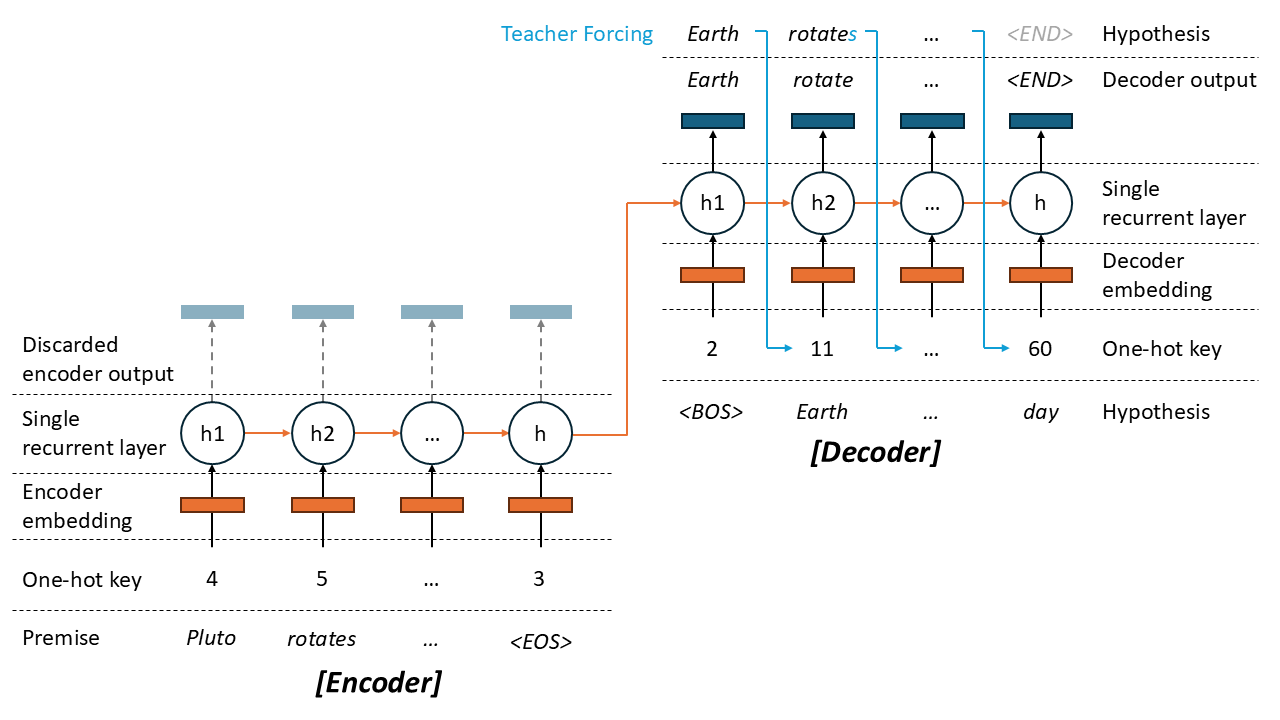

### 4.2.1 Model

In [ ]:
import torch.nn as nn

class RNN_Seq2Seq_Model(nn.Module):
  def __init__(self, shared):
    super().__init__()

    # Specialized hyperparameters
    self.num_layers = 1

    # Layer definitions
    self.embedding = nn.Embedding(shared.vocab_size, shared.embed_dim, padding_idx=shared.pad_idx)

    self.encoder = nn.RNN(
      shared.embed_dim, shared.hidden_dim,
      num_layers=self.num_layers,
      # dropout=shared.dropout,   # Dropout only applies between RNN layers
      batch_first=True
    )

    self.decoder = nn.RNN(
      shared.embed_dim, shared.hidden_dim,
      num_layers=self.num_layers,
      # dropout=shared.dropout,   # Dropout only applies between RNN layers
      batch_first=True
    )

    # Prevents overfitting
    self.dropout_encoder = nn.Dropout(shared.dropout)
    self.dropout_decoder = nn.Dropout(shared.dropout)

    self.linear = nn.Linear(shared.hidden_dim, shared.vocab_size)

  def forward(self, enc_in, dec_in):
    # Encoder
    enc_embed = self.embedding(enc_in)        # encoder embedding
    _, hidden = self.encoder(enc_embed)       # discard encoder output
    hidden = self.dropout_encoder(hidden)      # apply dropout layer to hidden state

    # Decoder
    dec_embed = self.embedding(dec_in)        # decoder embedding
    dec_out, _ = self.decoder(dec_embed, hidden)  # inherit hidden state, discard decoder final hidden state
    dec_out = self.dropout_decoder(dec_out)     # apply dropout layer to decoder output

    logits = self.linear(dec_out)          # decoder raw prediction

    return logits

### 4.2.2 Training (2 min)

In [ ]:
import torch.optim as optim

model = RNN_Seq2Seq_Model(shared).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=shared.pad_idx)     # combine LogSoftmax and NLLLoss
optimizer = optim.Adam(model.parameters(), lr=shared.learning_rate)

In [ ]:
train_loader = make_batch(train_df)
val_loader = make_batch(val_df)

for encoder_batch, decoder_batch, target_batch, _ in train_loader:  # discard label, because we only concern about how to generate a sequence
  # Move to device
  encoder_batch = encoder_batch.to(device)
  decoder_batch = decoder_batch.to(device)
  target_batch = target_batch.to(device)

  # Forward pass
  logits = model(encoder_batch, decoder_batch)
  loss = criterion(logits.view(-1, logits.size(-1)), target_batch.view(-1))

  # Backward and optimize
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

In [ ]:
train_epoch_losses = []
val_epoch_losses = []

for epoch in range(shared.total_epoch):
  model.train()
  train_loss = 0

  # Training loop
  for enc, dec, tar, _ in train_loader:
    enc, dec, tar = enc.to(device), dec.to(device), tar.to(device)
    optimizer.zero_grad()
    logits = model(enc, dec)    # enable teacher forcing
    loss = criterion(logits.view(-1, logits.size(-1)), tar.view(-1))
    loss.backward()
    optimizer.step()
    train_loss += loss.item()    # accumulate batch loss for this epoch

  train_avg_loss = train_loss / len(train_loader)
  train_epoch_losses.append(train_avg_loss)

  # Validation
  model.eval()
  val_loss = 0
  with torch.no_grad():
    for enc, dec, tar, _ in val_loader:
      enc, dec, tar = enc.to(device), dec.to(device), tar.to(device)
      logits = model(enc, dec)
      loss = criterion(logits.view(-1, logits.size(-1)), tar.view(-1))
      val_loss += loss.item()   # accumulate batch loss for this epoch

  val_avg_loss = val_loss / len(val_loader)
  val_epoch_losses.append(val_avg_loss)

  print(f"Epoch: {epoch+1}/{shared.total_epoch}\tTrain Loss: {train_avg_loss:.4f}\tVal Loss: {val_avg_loss:.4f}")

### 4.2.3 Loss curves

In [ ]:
import matplotlib.pyplot as plt

epoch = range(1, shared.total_epoch + 1)
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

# Training Loss
axes[0].plot(epoch, train_epoch_losses, marker='o', color='blue', label='Train Loss')
axes[0].set_title('Training Loss per Epoch')
axes[0].set_xticks(epoch)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Average Loss')
axes[0].grid(axis='y')

# Validation Loss
axes[1].plot(epoch, val_epoch_losses, marker='o', color='orange')
axes[1].set_title('Validation Loss per Epoch')
axes[1].set_xticks(epoch)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Average Loss')
axes[1].grid(axis='y')

plt.show()

### 4.2.4 Evaluation

In summary, the model struggles to predict OOV words, regardless of how much content it has learned from the training set.

#### Training Loss

The training loss decreases rapidly and stabilizes around epoch 10, indicating that the model successfully fits the training data.

The consistent convergence pattern suggests that our vanilla RNN encoder-decoder is capable of capturing the sequence patterns within the training distribution, even without advanced mechanisms such as attention or pre-trained embeddings.

#### Validation Loss

The validation loss rises steadily throughout training, revealing a clear sign of overfitting.

This outcome is expected. Since the word-to-index vocabulary was intentionally built only from the training set

As a result, unseen or rare tokens are replaced by the \<UNK> tag, leading to higher loss and reduced generalization capability.

## 4.3 The Bi-LSTM encoder-decoder with XXX-attention in different positions

Lab 7

## 4.4 The vanilla Transformer with self-attention

Lab 8

# 5. Performance Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

# 6. Interactive Inference Colab Form
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)